# Final Project
# AnimeGen - Anime Face Image Generation with Generative Adversarial Networks
# Kelvin K. Ahiakpor
# CS463: Computer Vision
# Dr. David Sasu
# December 14, 2025

### Project Overview
**Task**: Image Generation (Anime Faces)  
**Dataset**: Anime Face Dataset (Kaggle)  
**Model**: DCGAN (Deep Convolutional GAN)  
**Framework**: PyTorch/torchvision

### Imports

In [ ]:
import os
import gc
import time
import scipy
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm import tqdm
from PIL import Image
from pathlib import Path

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_recall_fscore_support,
                             ConfusionMatrixDisplay)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import Flowers102
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import copy
import time
from matplotlib import text


##### Custom recipes for Data Loading and Inspection

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

Custom recipes for Grids

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

Set random seeds for reproducibility

In [ ]:
RANDOM_SEED = 87
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Project Configuration

In [ ]:
class Config:
    """Central configuration for the entire project"""

    # Dataset Parameters
    DATASET_NAME = "AnimeFaceDataset"
    IMG_HEIGHT = 64
    IMG_WIDTH = 64
    IMG_CHANNELS = 3
    IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

    # GAN Architecture Parameters
    LATENT_DIM = 100  # Size of noise vector input to Generator
    GEN_FEATURES = 64  # Base number of features in Generator
    DISC_FEATURES = 64  # Base number of features in Discriminator

    # Training Parameters
    BATCH_SIZE = 128
    EPOCHS = 100
    LEARNING_RATE = 0.0002
    BETA1 = 0.5  # Adam optimizer beta1 parameter
    BETA2 = 0.999  # Adam optimizer beta2 parameter

    # Training Strategy
    DISC_TRAIN_RATIO = 1  # Train discriminator once per generator update
    LABEL_SMOOTHING = 0.9  # Use 0.9 instead of 1.0 for real labels
    LABEL_NOISE = 0.0  # Add noise to labels (start with 0, increase if needed)
    # Label noise is much like giving the detective some wrong clues so they don't become cocky
    # Example: flip some labels (make real→fake, fake→real)

    # Paths
    BASE_DIR = '/content'
    DATA_DIR = os.path.join(BASE_DIR, 'anime_data')
    MODEL_DIR = os.path.join(BASE_DIR, 'models')
    RESULTS_DIR = os.path.join(BASE_DIR, 'results')
    SAMPLE_DIR = os.path.join(RESULTS_DIR, 'samples')

    # Visualization & Logging
    SAMPLE_INTERVAL = 5  # Generate samples every N epochs
    NUM_SAMPLE_IMAGES = 64  # Number of images to generate for visualization (8x8 grid)
    FIXED_NOISE = None  # Will be set after initialization

    # Model Saving
    SAVE_INTERVAL = 10  # Save model every N epochs

    # Mixed Precision Training (if GPU available)
    USE_AMP = False  # GANs can be unstable with mixed precision, keep disabled

In [ ]:
# TESTING MODE: Use subset for faster iteration
USE_SUBSET = True  # Set to True for testing
SUBSET_SIZE = 10000

In [ ]:
# Create directories
os.makedirs(Config.DATA_DIR, exist_ok=True)
os.makedirs(Config.MODEL_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)
os.makedirs(Config.SAMPLE_DIR, exist_ok=True)

print(f"- Data: {Config.DATA_DIR}")
print(f"- Models: {Config.MODEL_DIR}")
print(f"- Results: {Config.RESULTS_DIR}")
print(f"- Samples: {Config.SAMPLE_DIR}")

- Data: /content/anime_data
- Models: /content/models
- Results: /content/results
- Samples: /content/results/samples


In [ ]:
# Copy zip from Drive to Colab workspace (faster processing)
!cp "/content/drive/MyDrive/anime faces.zip" {Config.DATA_DIR}/

# Phase 1
Task Selection

For this project, I chose anime face generation using Generative Adversarial Networks (GANs) - a task that involves learning to synthesize realistic anime character faces from random noise. I selected this task because it represents a significant step beyond classification, requiring
the model to understand and reproduce the complex visual patterns that define anime art style.

GANs are particularly well-suited for this domain because anime faces have consistent structural features (large eyes, simplified facial features, vibrant colors) that can be learned from data. This choice allows me to explore adversarial training dynamics and understand how neural networks
can capture creative domains beyond traditional object recognition.

# Phase 2
Dataset Selection

For this project, I selected the Anime Face Dataset from Kaggle, containing 63,565 high-quality anime faces scraped from [Getchu](www.getchu.com). Our team chose this dataset because:

1. **Homogeneity**: All images are cropped anime faces with clean backgrounds and consistent framing
2. **Size**: 63K images provides sufficient diversity for GAN training without overwhelming our 2-week timeline
3. **Quality**: Images are pre-processed (cropped to face and head) and range from 25x25 to 220x220 pixels, perfect for resizing to 64x64
4. **Established Benchmark**: This dataset has been successfully used in multiple DCGAN and WGAN implementations

The dataset's focus on anime faces (rather than full scenes) reduces complexity and allows the GAN to learn meaningful facial features within our computational constraints.

# Phase 3
Data Pre-processing

### Data Loading & Exploration


#### Defining Transforms

For GAN training, we will:
1. Resize all images to consistent 64x64 size
2. Convert images to tensors
3. Normalize to [-1, 1] range (for tanh activation in Generator output)

Note: We use minimal augmentation for GANs compared to classification tasks

In [ ]:
# GAN transforms (normalize to [-1, 1] for tanh)
gan_transforms = transforms.Compose([
    transforms.Resize(Config.IMG_SIZE),
    transforms.CenterCrop(Config.IMG_SIZE),
    transforms.ToTensor(),
    # Maps [0,1] to [-1,1]
    # Three values each because of RGB channels
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Transforms Defined:  
- Resize → CenterCrop(64x64) → Normalize([-1,1])

#### Load Anime Face Dataset

In [ ]:
# Unzip dataset
zip_path = os.path.join(Config.DATA_DIR, 'anime faces.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(Config.DATA_DIR)

print(f"Dataset extracted to {Config.DATA_DIR}")

Dataset extracted to /content/anime_data


In [ ]:
# Clean up zip file to save space
os.remove(zip_path)

In [ ]:
image_folder = '/content/anime_data/anime faces'

#### Create Data Loaders

In [ ]:
class SingleFolderDataset(Dataset):
    """Custom dataset for images in a single folder (no class subdirectories)"""

    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = [
            os.path.join(image_folder, f)
            for f in os.listdir(image_folder)
            if f.endswith(('.jpg', '.png', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0  # Return dummy label (GANs don't need labels)

In [ ]:
# Load dataset
anime_dataset = SingleFolderDataset(
    image_folder=image_folder,
    transform=gan_transforms
)

In [ ]:
print(USE_SUBSET)

True


In [ ]:
if USE_SUBSET:
    print(f"TESTING MODE: Using only {SUBSET_SIZE} images")
    indices = torch.randperm(len(anime_dataset))[:SUBSET_SIZE]
    anime_dataset = torch.utils.data.Subset(anime_dataset, indices)
    print(f"Subset created: {len(anime_dataset)} images")
    Config.EPOCHS = 100

TESTING MODE: Using only 10000 images
Subset created: 10000 images


I stuck with the 'testing' mode above for the actual training process

In [ ]:
dataloader = DataLoader(
    anime_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=2, # 2 CPU threads prep data → GPU never waits
    # Fast CPU→GPU transfer (only if GPU exists)
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=True  # Drop incomplete batch (16 images). Important for GAN training to keep batch size consistent
)

In [ ]:
print(f"Dataset Loaded:")
print(f"- Total images: {len(anime_dataset)}")
print(f"- Batches per epoch: {len(dataloader)}")
print(f"- Batch size: {Config.BATCH_SIZE}")

Dataset Loaded:
- Total images: 10000
- Batches per epoch: 78
- Batch size: 128


#### Exploratory Data Analysis (EDA)

**Dataset Statistics**

Collect image size information

In [ ]:
image_sizes = []
image_aspects = []
corrupted_images = []

In [ ]:
for filename in tqdm(os.listdir(image_folder)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, filename)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                image_sizes.append((width, height))
                image_aspects.append(width / height)
        except Exception as e:
            corrupted_images.append((filename, str(e)))

100%|██████████| 63566/63566 [00:04<00:00, 15690.98it/s]


In [ ]:
# Convert to arrays for analysis
widths = np.array([w for w, h in image_sizes])
heights = np.array([h for w, h in image_sizes])
aspects = np.array(image_aspects)

In [ ]:
print(f"- Total images analyzed: {len(image_sizes)}")
print(f"- Corrupted/unreadable images: {len(corrupted_images)}")

- Total images analyzed: 63565
- Corrupted/unreadable images: 0


In [ ]:
print(f"Image Dimensions:")
print(f"- Width  → Min: {widths.min()}px | Max: {widths.max()}px | Mean: {widths.mean():.1f}px | Median: {np.median(widths):.1f}px")
print(f"- Height → Min: {heights.min()}px | Max: {heights.max()}px | Mean: {heights.mean():.1f}px | Median: {np.median(heights):.1f}px")

Image Dimensions:
- Width  → Min: 25px | Max: 220px | Mean: 89.6px | Median: 91.0px
- Height → Min: 25px | Max: 220px | Mean: 89.6px | Median: 91.0px


In [ ]:
print(f"Aspect Ratios:")
print(f"- Min: {aspects.min():.3f} | Max: {aspects.max():.3f} | Mean: {aspects.mean():.3f}")
print(f"- Square images (ratio ≈ 1.0): {np.sum((aspects > 0.95) & (aspects < 1.05))} ({100*np.sum((aspects > 0.95) & (aspects < 1.05))/len(aspects):.1f}%)")

Aspect Ratios:
- Min: 1.000 | Max: 1.020 | Mean: 1.000
- Square images (ratio ≈ 1.0): 63565 (100.0%)


Check for image size imbalance

In [ ]:
size_bins = {
    'Tiny (<50px)': np.sum((widths < 50) | (heights < 50)),
    'Small (50-80px)': np.sum(((widths >= 50) & (widths < 80)) | ((heights >= 50) & (heights < 80))),
    'Medium (80-120px)': np.sum(((widths >= 80) & (widths < 120)) | ((heights >= 80) & (heights < 120))),
    'Large (120-180px)': np.sum(((widths >= 120) & (widths < 180)) | ((heights >= 120) & (heights < 180))),
    'Very Large (≥180px)': np.sum((widths >= 180) | (heights >= 180))
}

In [ ]:
print(f"Size Distribution:")
for category, count in size_bins.items():
    percentage = 100 * count / len(image_sizes)
    print(f"- {category}: {count:,} images ({percentage:.1f}%)")

Size Distribution:
- Tiny (<50px): 805 images (1.3%)
- Small (50-80px): 17,249 images (27.1%)
- Medium (80-120px): 42,353 images (66.6%)
- Large (120-180px): 3,134 images (4.9%)
- Very Large (≥180px): 24 images (0.0%)


In [ ]:
# Images smaller than target size
smaller_than_target = np.sum((widths < Config.IMG_WIDTH) | (heights < Config.IMG_HEIGHT))
print(f"Images smaller than 64x64 target: {smaller_than_target:,} ({100*smaller_than_target/len(image_sizes):.1f}%)")
print(f"These will be upsampled during training (may introduce blur)")

Images smaller than 64x64 target: 6,329 (10.0%)
These will be upsampled during training (may introduce blur)


**Visualize Class Distribution**

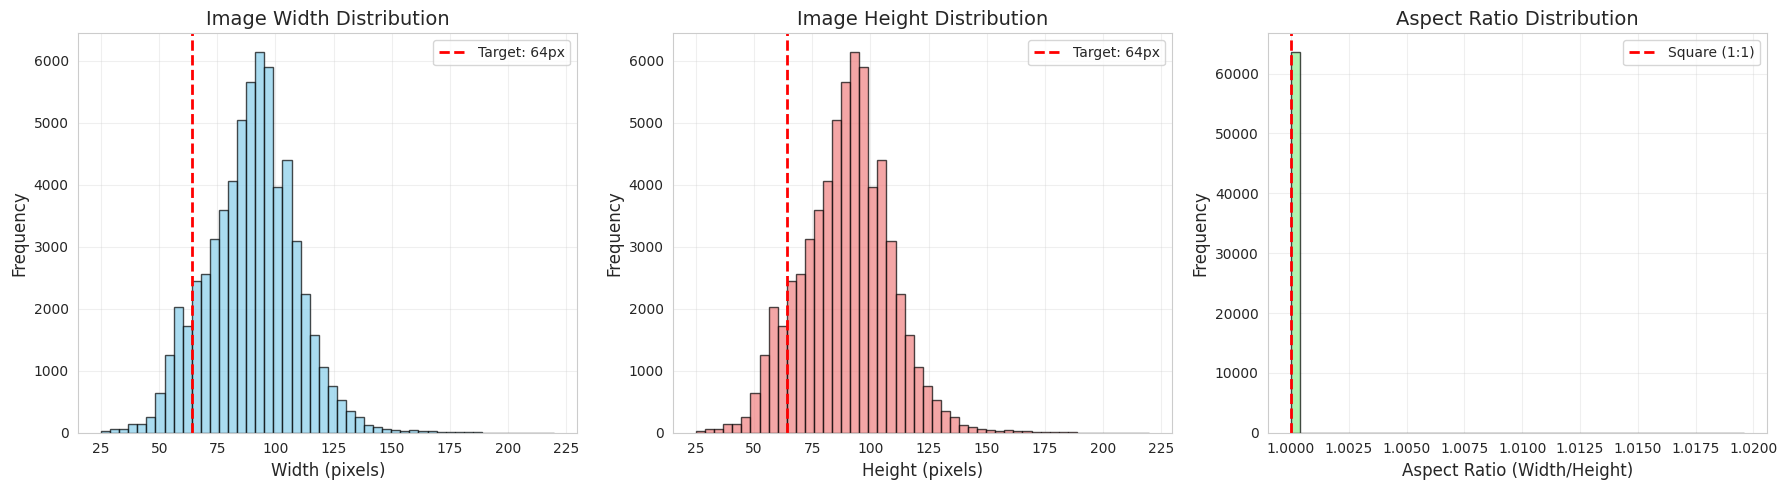

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Width distribution
axes[0].hist(widths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(Config.IMG_WIDTH, color='red', linestyle='--', linewidth=2, label=f'Target: {Config.IMG_WIDTH}px')
axes[0].set_xlabel('Width (pixels)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Image Width Distribution', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Height distribution
axes[1].hist(heights, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(Config.IMG_HEIGHT, color='red', linestyle='--', linewidth=2, label=f'Target: {Config.IMG_HEIGHT}px')
axes[1].set_xlabel('Height (pixels)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Image Height Distribution', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Aspect ratio distribution
axes[2].hist(aspects, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Square (1:1)')
axes[2].set_xlabel('Aspect Ratio (Width/Height)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Aspect Ratio Distribution', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'eda_size_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

Most images are square shaped. The only changing image characteristic across the dataset is the image sizes.

**Display Sample Images**

In [ ]:
def denormalize(tensor):
    """Convert tensor from [-1, 1] back to [0, 1] for visualization"""
    return tensor * 0.5 + 0.5

In [ ]:
# Get a batch of real images
real_batch = next(iter(dataloader))[0]

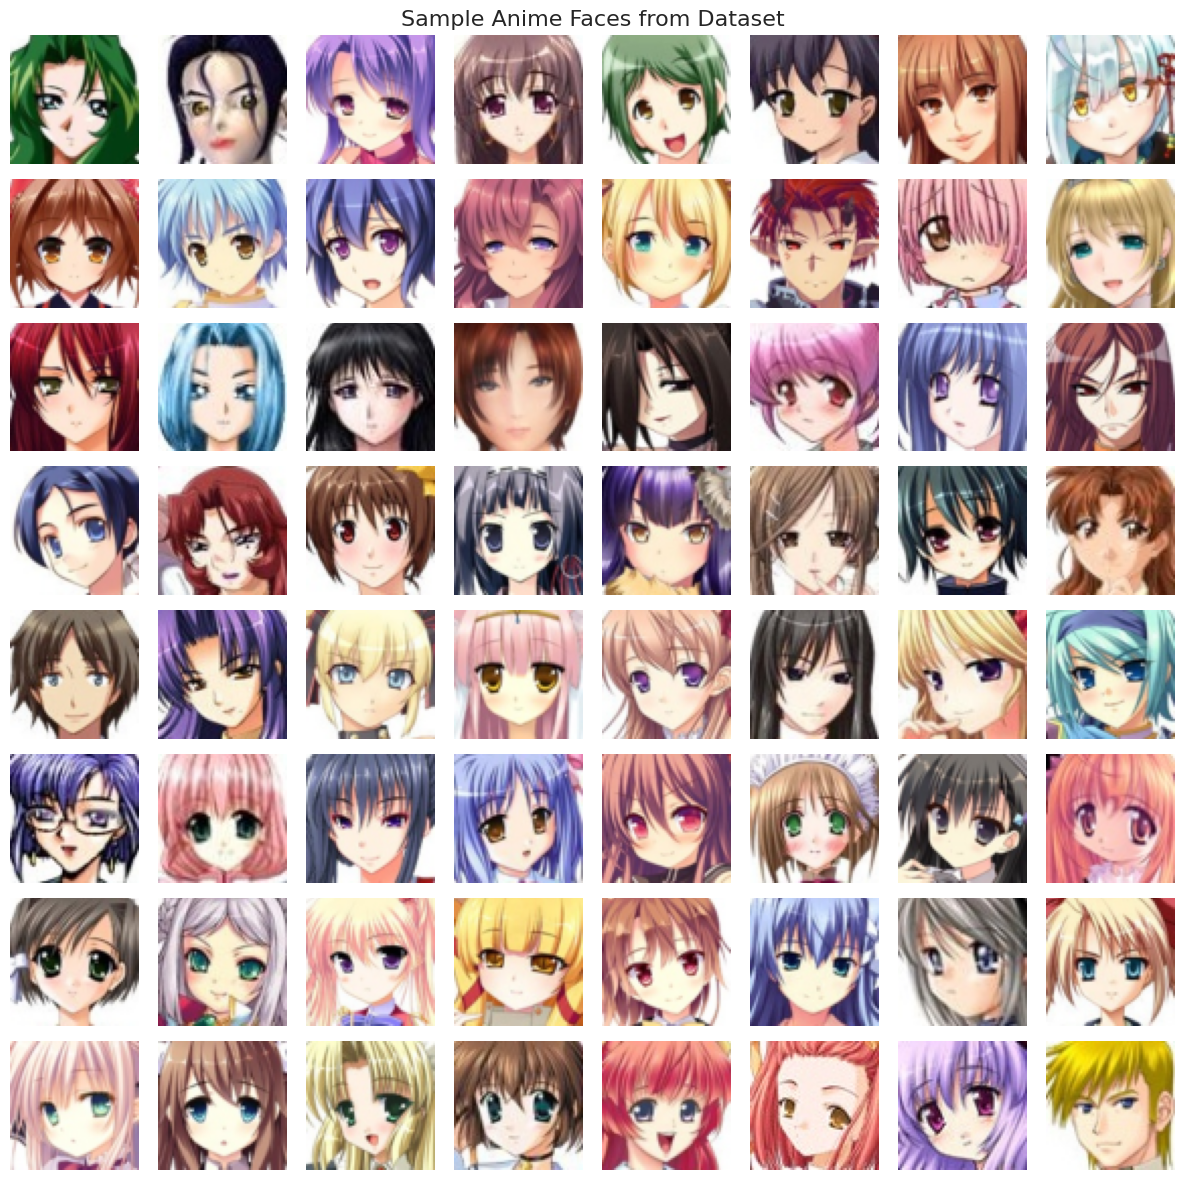

In [ ]:
# Plot 8x8 grid of real images
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
fig.suptitle('Sample Anime Faces from Dataset', fontsize=16)

for idx, ax in enumerate(axes.flat):
    if idx < len(real_batch):
        img = denormalize(real_batch[idx]).cpu()
        img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'dataset_samples.png'), dpi=150, bbox_inches='tight')
plt.show()

# Phase 4
Model Architecture

#### Generator Network

**Generator Architecture: Inverse Convolutional Network**

The Generator implements a decoder-style architecture that mirrors the Discriminator's structure in reverse. It progressively upsamples from a compact latent representation to full resolution.

Design principles:
- **Transposed convolutions** (ConvTranspose2d) for learnable upsampling
- **Symmetric to Discriminator** in depth (4 layers) and channel progression (512→64)
- **Batch normalization** after all layers except output for training stability
- **ReLU activations** in hidden layers, **Tanh output** to match normalized image range [-1, 1]

Architecture flow:  
Input (100D noise vector)  
→ Dense → Reshape --------------------------------------        # 512x4x4  
→ ConvTranspose(256, stride=2) → BatchNorm → ReLU   ----# 8x8  
→ ConvTranspose(128, stride=2) → BatchNorm → ReLU   ----# 16x16  
→ ConvTranspose(64, stride=2) → BatchNorm → ReLU    -----# 32x32  
→ ConvTranspose(3, stride=2) → Tanh --------------------- # 64x64 RGB image

In [ ]:
class Generator(nn.Module):
    """
    DCGAN Generator

    Takes a latent vector z (100D) and upsamples it to a 64x64x3 image
    Architecture: Dense → Reshape → ConvTranspose x4 → Tanh

    Key design choices:
    - Use ConvTranspose2d for upsampling
    - BatchNorm after each layer (except output)
    - ReLU activations (except Tanh at output)
    - Kernel size 4, stride 2, padding 1 for 2x upsampling
    """

    def __init__(self, latent_dim=100, gen_features=64, img_channels=3):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.gen_features = gen_features

        # Project and reshape: 100 -> 4x4x(gen_features*8)
        self.project = nn.Sequential(
            nn.Linear(latent_dim, gen_features * 8 * 4 * 4),
            nn.BatchNorm1d(gen_features * 8 * 4 * 4),
            nn.ReLU(True)
        )

        # Upsampling layers
        self.main = nn.Sequential(
            # State: (gen_features*8) x 4 x 4
            nn.ConvTranspose2d(gen_features * 8, gen_features * 4,
                             kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_features * 4),
            nn.ReLU(True),
            # State: (gen_features*4) x 8 x 8

            nn.ConvTranspose2d(gen_features * 4, gen_features * 2,
                             kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_features * 2),
            nn.ReLU(True),
            # State: (gen_features*2) x 16 x 16

            nn.ConvTranspose2d(gen_features * 2, gen_features,
                             kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gen_features),
            nn.ReLU(True),
            # State: gen_features x 32 x 32

            nn.ConvTranspose2d(gen_features, img_channels,
                             kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # State: img_channels x 64 x 64
            # Tanh outputs in [-1, 1] to match normalized images
        )

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights from normal distribution (DCGAN paper)"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)

    def forward(self, z):
        """
        Args:
            z: Latent vector of shape (batch_size, latent_dim)
        Returns:
            Generated images of shape (batch_size, 3, 64, 64)
        """
        batch_size = z.size(0)
        x = self.project(z)
        x = x.view(batch_size, self.gen_features * 8, 4, 4)
        x = self.main(x)
        return x

#### Discriminator Network

**Discriminator Architecture: VGG-Inspired Design**

The Discriminator follows VGGNet's design philosophy of progressive channel expansion
through deep convolutional layers. Like VGG, we increase feature channels systematically
(64→128→256→512) while reducing spatial dimensions. Key adaptations for GAN training:

- **Strided convolutions** replace max-pooling for learnable downsampling
- **Fully convolutional** design (no dense layers except final 1x1 classification)
- **Batch normalization** stabilizes adversarial training (applied after Conv layers 2-4)
- **LeakyReLU(0.2)** prevents dying gradients during discriminator updates

Architecture flow:  
Input (64x64)   
→ Conv(64, stride=2) → LeakyReLU ---------------------------------# 32x32  
→ Conv(128, stride=2) → BatchNorm → LeakyReLU ----------------- # 16x16  
→ Conv(256, stride=2) → BatchNorm → LeakyReLU ----------------- # 8x8  
→ Conv(512, stride=2) → BatchNorm → LeakyReLU ----------------- # 4x4  
→ Conv(1) → Sigmoid ---------------------------------------------- # 1x1 (real/fake probability)  

In [ ]:
class Discriminator(nn.Module):
    """
    DCGAN Discriminator

    Takes a 64x64x3 image and classifies it as real or fake
    Architecture: Conv x4 → Flatten → Dense → Sigmoid

    Design choices (DCGAN-inspired):
    - Use strided Conv2d for downsampling (no pooling)
    - BatchNorm on all layers (except first and last)
    - LeakyReLU(0.2) activations
    - Kernel size 4, stride 2, padding 1 for 2x downsampling
    - No BatchNorm on first layer (DCGAN paper recommendation)
    """

    def __init__(self, img_channels=3, disc_features=64):
        super(Discriminator, self).__init__()

        self.disc_features = disc_features

        self.main = nn.Sequential(
            # Input: img_channels x 64 x 64
            nn.Conv2d(img_channels, disc_features,
                     kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: disc_features x 32 x 32

            nn.Conv2d(disc_features, disc_features * 2,
                     kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(disc_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (disc_features*2) x 16 x 16

            nn.Conv2d(disc_features * 2, disc_features * 4,
                     kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(disc_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (disc_features*4) x 8 x 8

            nn.Conv2d(disc_features * 4, disc_features * 8,
                     kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(disc_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (disc_features*8) x 4 x 4

            nn.Conv2d(disc_features * 8, 1,
                     kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # State: 1 x 1 x 1
            # Sigmoid outputs probability [0, 1]
        )

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights from normal distribution (DCGAN paper)"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)

    def forward(self, img):
        """
        Args:
            img: Images of shape (batch_size, 3, 64, 64)
        Returns:
            Probability of being real, shape (batch_size, 1)
        """
        validity = self.main(img)
        return validity.view(-1, 1)

#### Model Initialization

In [ ]:
# Create Generator and Discriminator
netG = Generator(
    latent_dim=Config.LATENT_DIM,
    gen_features=Config.GEN_FEATURES,
    img_channels=Config.IMG_CHANNELS
).to(device)

In [ ]:
netD = Discriminator(
    img_channels=Config.IMG_CHANNELS,
    disc_features=Config.DISC_FEATURES
).to(device)

In [ ]:
netG

Generator(
  (project): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh(

In [ ]:
print(f"Generator Parameters: {sum(p.numel() for p in netG.parameters()):,}")

Generator Parameters: 3,600,256


In [ ]:
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
print(f"Discriminator Parameters: {sum(p.numel() for p in netD.parameters()):,}")

Discriminator Parameters: 2,765,568


#### Test Forward Pass

In [ ]:
# Test Generator
test_noise = torch.randn(8, Config.LATENT_DIM).to(device)
test_fake_images = netG(test_noise)
print(f"Generator Test:")
print(f"Input shape: {test_noise.shape}")
print(f"Output shape: {test_fake_images.shape}")

Generator Test:
Input shape: torch.Size([8, 100])
Output shape: torch.Size([8, 3, 64, 64])


In [ ]:
# Test Discriminator
test_predictions = netD(test_fake_images.detach())
print(f"Discriminator Test:")
print(f"Input shape: {test_fake_images.shape}")
print(f"Output shape: {test_predictions.shape}")

Discriminator Test:
Input shape: torch.Size([8, 3, 64, 64])
Output shape: torch.Size([8, 1])


**Create fixed noise for consistent sampling during training**

In [ ]:
Config.FIXED_NOISE = torch.randn(Config.NUM_SAMPLE_IMAGES, Config.LATENT_DIM).to(device)

# Phase 5
GAN Training

#### Training Setup

**Loss Function & Optimizers**

In [ ]:
# Binary Cross Entropy Loss
criterion = nn.BCELoss()

In [ ]:
# Optimizers (Adam with beta1=0.5 as per DCGAN paper)
optimizerD = optim.Adam(
    netD.parameters(),
    lr=Config.LEARNING_RATE,
    betas=(Config.BETA1, Config.BETA2)
)

In [ ]:
optimizerG = optim.Adam(
    netG.parameters(),
    lr=Config.LEARNING_RATE,
    betas=(Config.BETA1, Config.BETA2)
)

**Training Utilities**

In [ ]:
def save_checkpoint(generator, discriminator, epoch, g_losses, d_losses, filename):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_losses': g_losses,
        'd_losses': d_losses,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")

In [ ]:

def generate_samples(generator, fixed_noise, epoch, save_path):
    """Generate and save a grid of sample images"""
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        fake_images = denormalize(fake_images)

    # Create grid
    grid = torchvision.utils.make_grid(fake_images, nrow=8, padding=2, normalize=False)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(grid.cpu().permute(1, 2, 0).numpy())
    ax.set_title(f'Generated Samples - Epoch {epoch}', fontsize=16)
    ax.axis('off')

    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    generator.train()

In [ ]:
def plot_losses(g_losses, d_losses, save_path):
    """Plot Generator and Discriminator losses"""
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(g_losses, label='Generator Loss', linewidth=2, alpha=0.8)
    ax.plot(d_losses, label='Discriminator Loss', linewidth=2, alpha=0.8)
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('GAN Training Loss Curves', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.show()

#### Model Training

GAN Training Algorithm:
1. Train Discriminator:
   - Maximize log(D(x)) + log(1 - D(G(z)))
   - Feed real images, compute loss with label=1
   - Generate fake images, compute loss with label=0
   - Update D
   
2. Train Generator:
   - Maximize log(D(G(z))) (or equivalently, minimize log(1 - D(G(z))))
   - Generate fake images, compute loss with label=1 (fool discriminator)
   - Update G

Key tricks:
- Label smoothing: Use 0.9 instead of 1.0 for real labels
- Use same batch size throughout
- Monitor loss balance (neither should go to 0)

In [ ]:
# Training history
G_losses = []
D_losses = []
iters = 0

# Labels for real/fake
real_label = Config.LABEL_SMOOTHING
fake_label = 0.0

In [ ]:
for epoch in range(Config.EPOCHS):
    epoch_start_time = time.time()

    epoch_g_loss = 0.0
    epoch_d_loss = 0.0

    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        ############################
        # (1) Update Discriminator
        ############################
        netD.zero_grad()

        # Train with real images
        labels_real = torch.full((batch_size, 1), real_label, dtype=torch.float, device=device)
        output_real = netD(real_images)
        errD_real = criterion(output_real, labels_real)
        errD_real.backward()
        D_x = output_real.mean().item()

        # Train with fake images
        noise = torch.randn(batch_size, Config.LATENT_DIM, device=device)
        fake_images = netG(noise)
        labels_fake = torch.full((batch_size, 1), fake_label, dtype=torch.float, device=device)
        output_fake = netD(fake_images.detach())
        errD_fake = criterion(output_fake, labels_fake)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()

        # Total discriminator loss
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update Generator
        ############################
        netG.zero_grad()

        # Generator wants discriminator to think fakes are real
        labels_real = torch.full((batch_size, 1), real_label, dtype=torch.float, device=device)
        output = netD(fake_images)
        errG = criterion(output, labels_real)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        epoch_g_loss += errG.item()
        epoch_d_loss += errD.item()

        iters += 1

        # Progress update
        if i % 100 == 0:
            print(f"[{epoch+1}/{Config.EPOCHS}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

    # Epoch summary
    epoch_time = time.time() - epoch_start_time
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_d_loss = epoch_d_loss / len(dataloader)

    print(f"\n{'='*80}")
    print(f"Epoch {epoch+1}/{Config.EPOCHS} Summary:")
    print(f"- Time: {epoch_time:.2f}s")
    print(f"- Avg Generator Loss: {avg_g_loss:.4f}")
    print(f"- Avg Discriminator Loss: {avg_d_loss:.4f}")
    print(f"{'='*80}\n")

    # Generate samples at intervals
    if (epoch + 1) % Config.SAMPLE_INTERVAL == 0 or epoch == 0:
        sample_path = os.path.join(Config.SAMPLE_DIR, f'samples_epoch_{epoch+1:03d}.png')
        generate_samples(netG, Config.FIXED_NOISE, epoch+1, sample_path)
        print(f"Samples saved: {sample_path}\n")

    # Save checkpoint at intervals
    if (epoch + 1) % Config.SAVE_INTERVAL == 0:
        checkpoint_path = os.path.join(Config.MODEL_DIR, f'checkpoint_epoch_{epoch+1:03d}.pth')
        save_checkpoint(netG, netD, epoch+1, G_losses, D_losses, checkpoint_path)
        print()

[1/100][0/78] Loss_D: 1.5939 Loss_G: 2.5191 D(x): 0.3215 D(G(z)): 0.2591/0.0830

Epoch 1/100 Summary:
- Time: 15.84s
- Avg Generator Loss: 10.7102
- Avg Discriminator Loss: 0.9358

Samples saved: /content/results/samples/samples_epoch_001.png

[2/100][0/78] Loss_D: 0.7101 Loss_G: 6.5652 D(x): 0.7391 D(G(z)): 0.0177/0.0021

Epoch 2/100 Summary:
- Time: 15.57s
- Avg Generator Loss: 5.9568
- Avg Discriminator Loss: 0.7767

[3/100][0/78] Loss_D: 0.5232 Loss_G: 4.3215 D(x): 0.8780 D(G(z)): 0.0661/0.0117

Epoch 3/100 Summary:
- Time: 15.47s
- Avg Generator Loss: 5.3007
- Avg Discriminator Loss: 0.6840

[4/100][0/78] Loss_D: 0.5745 Loss_G: 4.7711 D(x): 0.8747 D(G(z)): 0.1135/0.0089

Epoch 4/100 Summary:
- Time: 15.36s
- Avg Generator Loss: 4.3647
- Avg Discriminator Loss: 0.7503

[5/100][0/78] Loss_D: 0.6843 Loss_G: 2.8062 D(x): 0.6976 D(G(z)): 0.0732/0.0561

Epoch 5/100 Summary:
- Time: 15.31s
- Avg Generator Loss: 4.4951
- Avg Discriminator Loss: 0.8002

Samples saved: /content/results/samp

# Phase 6
Results & Evaluation

**Generate final grid of samples using the trained Generator**

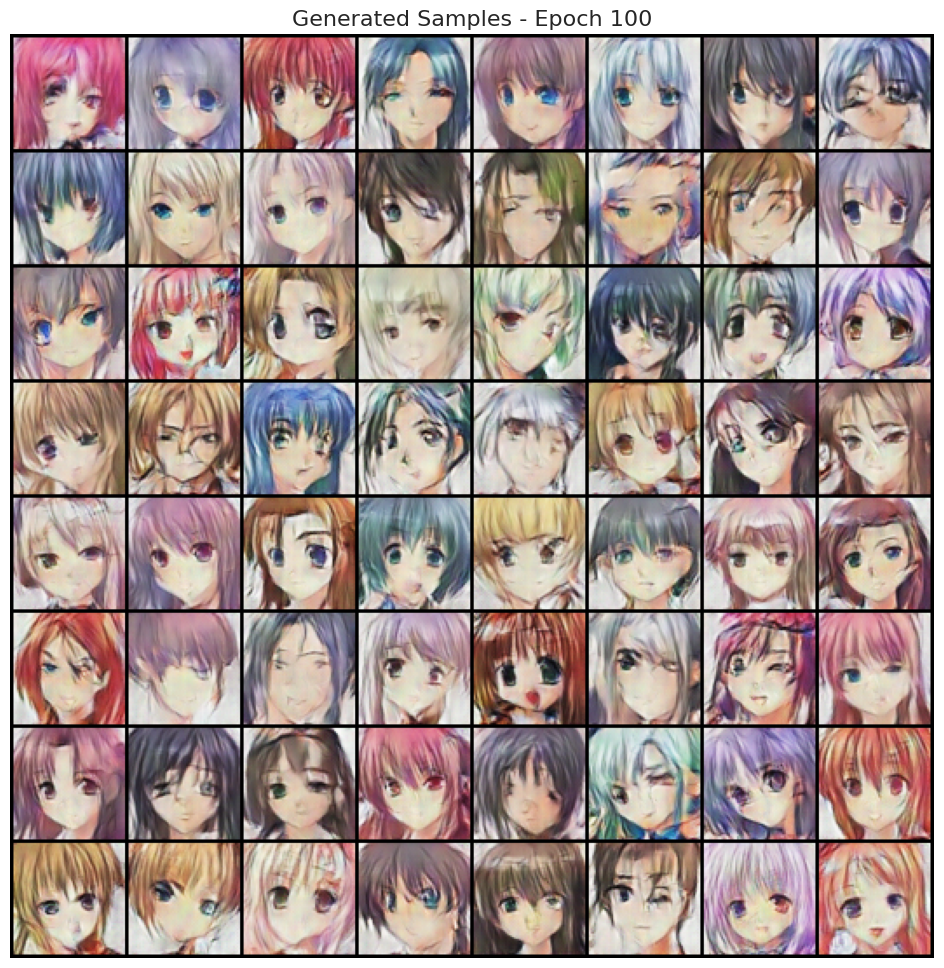

In [ ]:
final_sample_path = os.path.join(Config.RESULTS_DIR, 'final_samples.png')
generate_samples(netG, Config.FIXED_NOISE, Config.EPOCHS, final_sample_path)

**Plot Generator vs Discriminator loss over training**

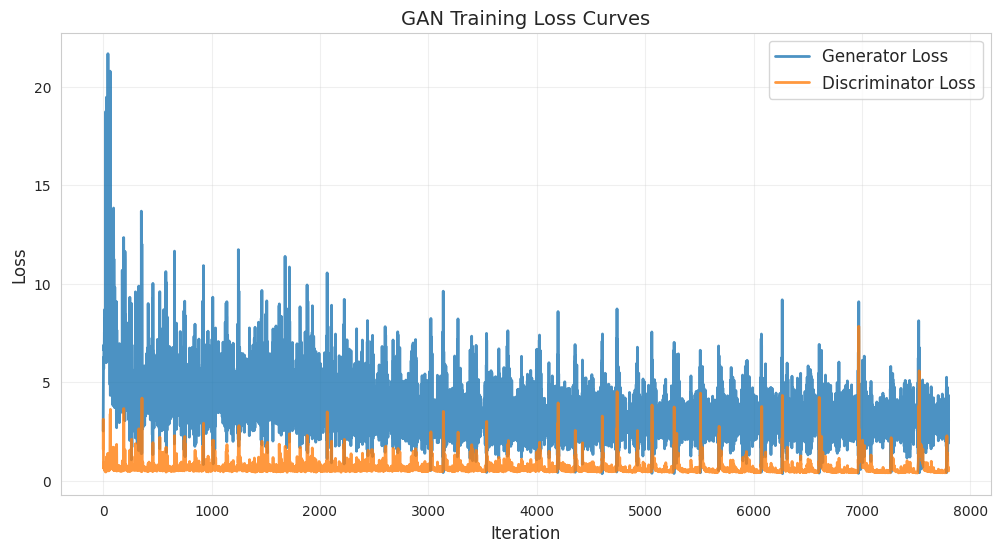

In [ ]:
loss_curve_path = os.path.join(Config.RESULTS_DIR, 'loss_curves.png')
plot_losses(G_losses, D_losses, loss_curve_path)

In [ ]:
# Find all saved sample images
sample_files = sorted([f for f in os.listdir(Config.SAMPLE_DIR) if f.startswith('samples_epoch_')])

### Training Progression Visualization

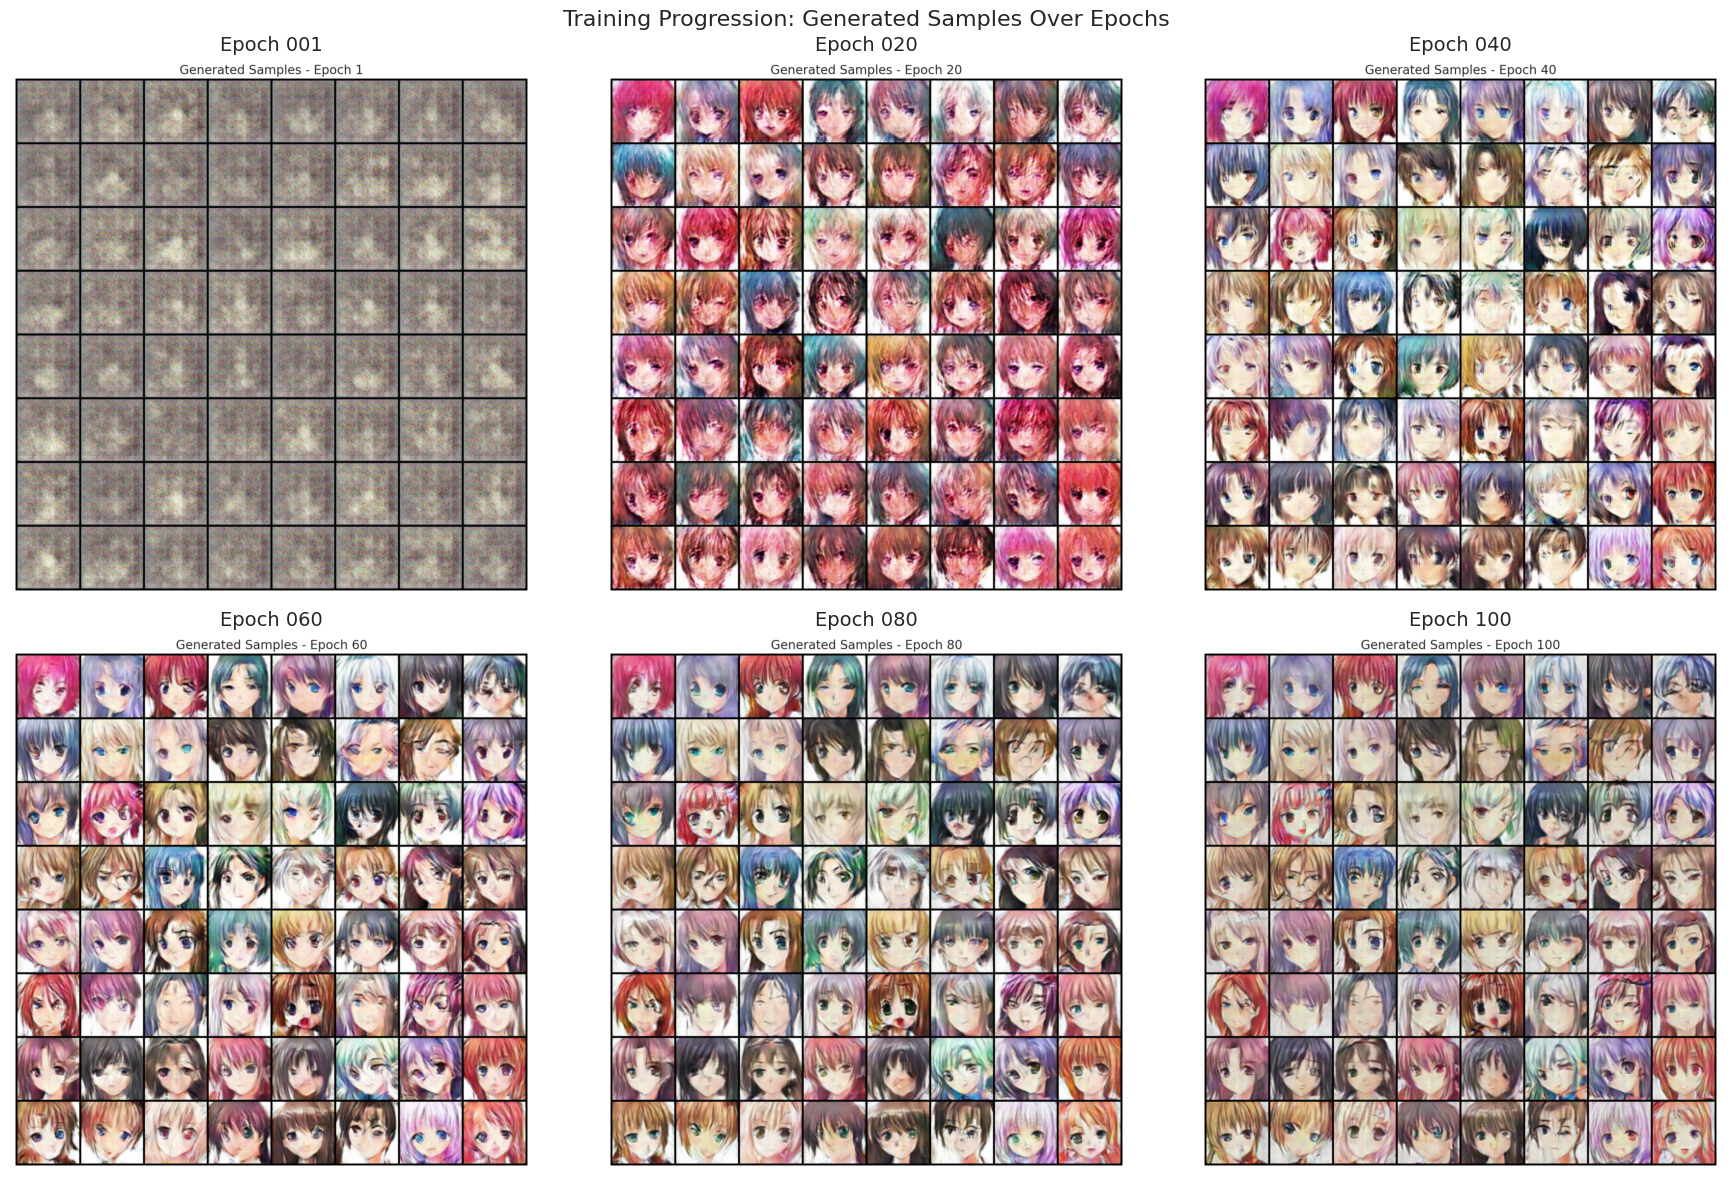

In [ ]:
# Find all saved sample images
sample_files = sorted([f for f in os.listdir(Config.SAMPLE_DIR) if f.startswith('samples_epoch_')])

# Select 6 evenly spaced epochs to show progression
if len(sample_files) >= 5:
    indices = np.linspace(0, len(sample_files)-1, 6, dtype=int)
    selected_samples = [sample_files[i] for i in indices]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Training Progression: Generated Samples Over Epochs', fontsize=16)

    for idx, (ax, sample_file) in enumerate(zip(axes.flat, selected_samples)):
        img_path = os.path.join(Config.SAMPLE_DIR, sample_file)
        img = plt.imread(img_path)
        ax.imshow(img)

        # Extract epoch number from filename
        epoch_num = sample_file.split('_')[-1].replace('.png', '')
        ax.set_title(f'Epoch {epoch_num}', fontsize=14)
        ax.axis('off')

    plt.tight_layout()
    progression_path = os.path.join(Config.RESULTS_DIR, 'training_progression.png')
    plt.savefig(progression_path, dpi=150, bbox_inches='tight')
    plt.show()

#### Save Final Models


In [ ]:
# Save final trained models
final_model_path = os.path.join(Config.MODEL_DIR, 'final_dcgan.pth')
save_checkpoint(netG, netD, Config.EPOCHS, G_losses, D_losses, final_model_path)

Checkpoint saved: /content/models/final_dcgan.pth


### Loss Curve Analysis
Key things to check:
- Neither loss goes to 0 (indicates mode collapse or one network dominating)
- Losses should oscillate but remain relatively balanced
- Generator loss should generally decrease over time

In [ ]:
loss_curve_path = os.path.join(Config.RESULTS_DIR, 'loss_curves.png')
plot_losses(G_losses, D_losses, loss_curve_path)

# Phase 8
Project Report

In [ ]:
print("Training Results:")
print(f"   • Final Generator Loss: {G_losses[-1]:.4f}")
print(f"   • Final Discriminator Loss: {D_losses[-1]:.4f}")
print(f"   • Average Generator Loss: {np.mean(G_losses):.4f}")
print(f"   • Average Discriminator Loss: {np.mean(D_losses):.4f}")
print(f"   • Loss Std Dev (G): {np.std(G_losses):.4f}")
print(f"   • Loss Std Dev (D): {np.std(D_losses):.4f}")

# Training stability check
loss_ratio = np.mean(G_losses) / np.mean(D_losses)
print(f"Training Balance:")
print(f"   • G/D Loss Ratio: {loss_ratio:.2f}")
if 0.5 < loss_ratio < 2.0:
    print(f"Well-balanced (neither network dominated)")
elif loss_ratio >= 2.0:
    print(f"Generator struggled more since D too strong")
else:
    print(f"Discriminator struggled more since G too strong")

Training Results:
   • Final Generator Loss: 3.0355
   • Final Discriminator Loss: 0.4955
   • Average Generator Loss: 3.6628
   • Average Discriminator Loss: 0.6730
   • Loss Std Dev (G): 1.5962
   • Loss Std Dev (D): 0.3615
Training Balance:
   • G/D Loss Ratio: 5.44
Generator struggled more since D too strong


### Next Steps for Report:
   1. Introduction - Describe anime face generation problem and why GANs
   2. Methodology - Dataset details, DCGAN architecture, training setup
   3. Results - Generated samples grid, loss curves, training progression
   4. Ethics & Impact - Copyright, deepfakes, artist impact, bias
   5. Reflection - Hardest parts, limitations, future work
   6. References - Cite Goodfellow (GAN), Radford (DCGAN), dataset source